Loading dataset and extracting MFCC features for both tasks...
Processing speaker: Benjamin_Netanyau
Processing speaker: Jens_Stoltenberg
Processing speaker: Julia_Gillard
Processing speaker: Magaret_Tarcher
Processing speaker: Nelson_Mandela
Processing speaker: other
Processing speaker: _background_noise_
Training the SVM Classifier...
Evaluating the classifier on the holdout set...
Classification Accuracy: 98.54%

Classification Report:
                   precision    recall  f1-score   support

Benjamin_Netanyau       0.96      0.99      0.98       157
 Jens_Stoltenberg       0.99      0.96      0.97       159
    Julia_Gillard       1.00      1.00      1.00       151
  Magaret_Tarcher       0.98      0.99      0.98       146
   Nelson_Mandela       1.00      1.00      1.00       137
            other       1.00      0.00      0.00         1

         accuracy                           0.99       751
        macro avg       0.99      0.82      0.82       751
     weighted avg       

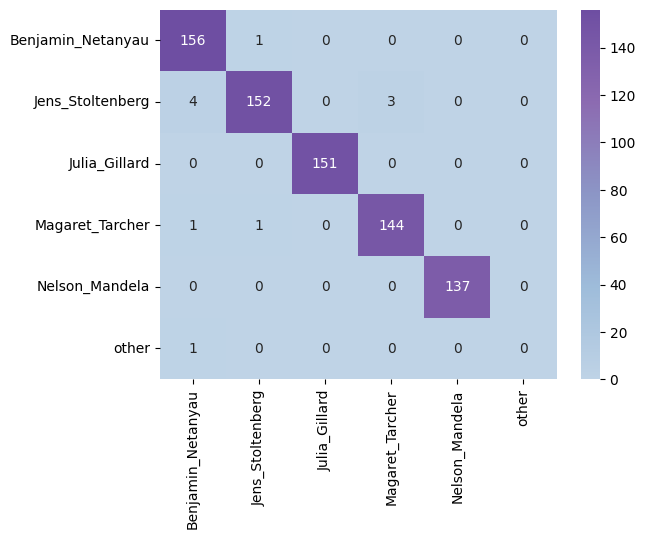

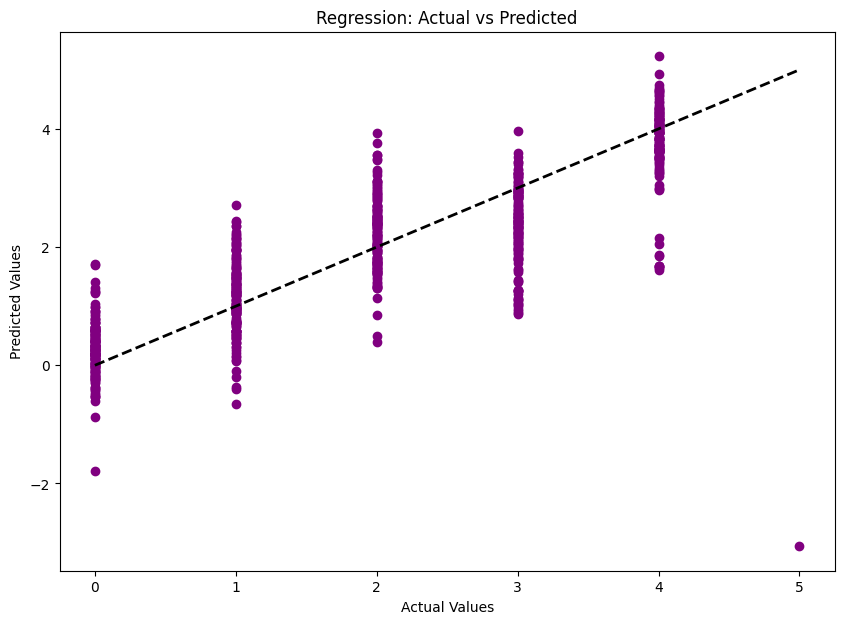


--- Comparison of Results ---
Classification Accuracy: 98.54%
Regression MSE: 0.58
Regression R²: 0.71


In [ ]:
import librosa
import numpy as np
from sklearn.svm import SVC, SVR  
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
def extract_mfcc_manual(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=None)  
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  #extract MFCC
        mfcc_mean = np.mean(mfcc.T, axis=0)  #take the mean across time
        return mfcc_mean
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
    
#load dataset and extract features for both tasks
def load_dataset_for_comparison(dataset_path):
    X = [] 
    y_class = [] 
    y_reg = []  
    label_map = {}  
    current_label = 0

    for speaker_folder in os.listdir(dataset_path):
        speaker_path = os.path.join(dataset_path, speaker_folder)
        
        if os.path.isdir(speaker_path):  #check if directory
            print(f"Processing speaker: {speaker_folder}")
            label_map[current_label] = speaker_folder  #map label to speaker name
            
            #speaker index as the continuous target for regression
            target_value = current_label  
            for file in os.listdir(speaker_path):
                if file.endswith('.wav'):  #only .wav files
                    file_path = os.path.join(speaker_path, file)
                    mfcc_features = extract_mfcc_manual(file_path)  
                    if mfcc_features is not None:
                        X.append(mfcc_features)
                        y_class.append(current_label)  
                        y_reg.append(target_value)  
            
            current_label += 1
    
    return np.array(X), np.array(y_class), np.array(y_reg), label_map

#main function for training both models
def main_comparison():
    dataset_path = "c:/Users/shrav/archive/16000_pcm_speeches"  #update with your dataset path
    
    #load dataset and extract features
    print("Loading dataset and extracting MFCC features for both tasks...")
    X, y_class, y_reg, label_map = load_dataset_for_comparison(dataset_path)
    
    if len(X) == 0 or len(y_class) == 0 or len(y_reg) == 0:
        print("No valid audio data found. Please check the dataset path and structure.")
        return

    #train/test split
    X_train, X_holdout, y_class_train, y_class_holdout, y_reg_train, y_reg_holdout = train_test_split(X, y_class, y_reg, test_size=0.1, random_state=42)

    #CLASSIFICATION MODLE
    print("Training the SVM Classifier...")
    classifier = SVC(kernel='linear')
    classifier.fit(X_train, y_class_train)
    
    #predict and evaluate the clas. model
    print("Evaluating the classifier on the holdout set...")
    y_class_pred = classifier.predict(X_holdout)
    accuracy = accuracy_score(y_class_holdout, y_class_pred)
    print(f"Classification Accuracy: {accuracy * 100:.2f}%\n")
    
    unique_labels = np.unique(y_class_holdout)
    target_names = [label_map[label] for label in unique_labels]
    
    print("Classification Report:")
    print(classification_report(y_class_holdout, y_class_pred, target_names=target_names, labels=unique_labels, zero_division=1))

    from matplotlib.colors import LinearSegmentedColormap


    if len(y_class_pred) == 0 or len(y_class_holdout) == 0:
        print("Error: No predictions were made. Please check the dataset.")
        return  #exit if no data to process

    cm = confusion_matrix(y_class_holdout, y_class_pred, labels=unique_labels)
    colors = ["#bfd3e6", "#9ebcda", "#8c96c6", "#8c6bb1", "#6e4ea2"] 
    custom_cmap = LinearSegmentedColormap.from_list("custom_bupu", colors, N=256)

    sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, xticklabels=target_names, yticklabels=target_names)


    #REGRESSION MODEL
    print("Training the SVM Regressor...")
    regressor = SVR(kernel='linear')
    regressor.fit(X_train, y_reg_train)
    
    #predict and eval regression model
    print("Evaluating the regressor on the holdout set...")
    y_reg_pred = regressor.predict(X_holdout)
    
    mse = mean_squared_error(y_reg_holdout, y_reg_pred)
    r2 = r2_score(y_reg_holdout, y_reg_pred)
    
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # plot regression
    plt.figure(figsize=(10, 7))
    plt.scatter(y_reg_holdout, y_reg_pred, color='purple')
    plt.plot([y_reg_holdout.min(), y_reg_holdout.max()], [y_reg_holdout.min(), y_reg_holdout.max()], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Regression: Actual vs Predicted')
    plt.show()

    #comparison
    print("\n--- Comparison of Results ---")
    print(f"Classification Accuracy: {accuracy * 100:.2f}%")
    print(f"Regression MSE: {mse:.2f}")
    print(f"Regression R²: {r2:.2f}")

if __name__ == "__main__":
    main_comparison()
